# Airbnb Open Data — Data Analysis Pipeline
Comprehensive data preparation, feature engineering, visualization, and statistical exploration for the Airbnb Open Data extract.

## Project Roadmap
1. Data Collection.
2. Systematic cleaning — duplicates, missingness, type fixes, and outlier handling.
3. Feature enrichment to unlock richer exploratory questions.
4. Univariate, bivariate, and multivariate deep dives with clean visuals.
5. Temporal trends with rolling signals.
6. Inferential statistics (t-test, chi-square, ANOVA) to validate hypotheses.
7. Insight synthesis.

## 1. Environment Setup
Install and import the libraries used throughout the notebook.

In [121]:

import importlib
import subprocess
import sys

required_packages = {
    'pandas': 'pandas',
    'numpy': 'numpy',
    'seaborn': 'seaborn',
    'matplotlib': 'matplotlib',
    'plotly': 'plotly',
    'folium': 'folium',
    'scipy': 'scipy',
    'statsmodels': 'statsmodels'
}

for import_name, package_name in required_packages.items():
    try:
        importlib.import_module(import_name)
    except ImportError:
        print(f'Installing {package_name}...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package_name])

print('Package check complete.')

Package check complete.


In [122]:
# Import libraries and configure notebook aesthetics
from pathlib import Path
from datetime import datetime
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
import statsmodels.api as sm
from IPython.display import display, HTML

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', palette='viridis')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')


# Define paths
PROJECT_DIR = Path.cwd()
DATA_PATH = r'1730285881-Airbnb_Open_Data.xlsx'
OUTPUT_DIR = PROJECT_DIR / 'outputs'
FIGURES_DIR = OUTPUT_DIR / 'figures'

for directory in [OUTPUT_DIR, FIGURES_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

DATA_PATH

'1730285881-Airbnb_Open_Data.xlsx'

In [123]:
import plotly.io as pio
import plotly.io._renderers as _renderers
import nbformat
_renderers.nbformat = nbformat
pio.renderers.default = 'notebook'
print('Plotly renderer default:', pio.renderers.default)


Plotly renderer default: notebook


## 2. Data Ingestion & Health Check

In [124]:
# Load the dataset

df_raw = pd.read_excel(DATA_PATH)

df = df_raw.copy()



# Standardise column names for easier referencing

df.columns = (

    df.columns

    .str.strip()

    .str.lower()

    .str.replace(' ', '_')

    .str.replace('/', '_')

    .str.replace('-', '_')

    .str.replace('__', '_')

)



print(f'Loaded {df.shape[0]:,} rows and {df.shape[1]:,} columns.')

display(df.head(3))

Loaded 102,599 rows and 26 columns.


id                                 name      host_id  \
0  1001254   Clean & quiet apt home by the park  80014485718   
1  1002102                Skylit Midtown Castle  52335172823   
2  1002403  THE VILLAGE OF HARLEM....NEW YORK !  78829239556   

  host_identity_verified host_name neighbourhood_group neighbourhood   lat  \
0            unconfirmed  Madaline            Brooklyn    Kensington 40.65   
1               verified     Jenna           Manhattan       Midtown 40.75   
2                    NaN     Elise           Manhattan        Harlem 40.81   

    long        country  ... service_fee  minimum_nights number_of_reviews  \
0 -73.97  United States  ...      193.00           10.00              9.00   
1 -73.98  United States  ...       28.00           30.00             45.00   
2 -73.94  United States  ...      124.00            3.00              0.00   

  last_review  reviews_per_month  review_rate_number  \
0  2021-10-19               0.21                4.00   
1  2022-05-21               0.38                4.00   
2         NaT                NaN                5.00   

   calculated_host_listings_count  availability_365  \
0                            6.00            286.00   
1                            2.00            228.00   
2                            1.00            352.00   

                                         house_rules license  
0  Clean up and treat the home the way you'd like...     NaN  
1  Pet friendly but please confirm with me if the...     NaN  
2  I encourage you to use my kitchen, cooking and...     NaN  

[3 rows x 26 columns]

In [125]:
# Snapshot of data types, missing values, and basic stats
overview = pd.DataFrame({
    'dtype': df.dtypes,
    'missing_count': df.isna().sum(),
    'missing_%': df.isna().mean().mul(100)
}).sort_values('missing_%', ascending=False)
display(overview.head(20))

display(df.describe(include=[np.number]).T.head(10))
display(df.describe(include=['object']).T.head(10))

dtype  missing_count  missing_%
license                                 object         102597     100.00
house_rules                             object          54843      53.45
last_review                     datetime64[ns]          15893      15.49
reviews_per_month                      float64          15879      15.48
country                                 object            532       0.52
availability_365                       float64            448       0.44
minimum_nights                         float64            409       0.40
host_name                               object            408       0.40
review_rate_number                     float64            326       0.32
calculated_host_listings_count         float64            319       0.31
host_identity_verified                  object            289       0.28
service_fee                            float64            273       0.27
name                                    object            270       0.26
price                                  float64            247       0.24
construction_year                      float64            214       0.21
number_of_reviews                      float64            183       0.18
country_code                            object            131       0.13
instant_bookable                       float64            105       0.10
cancellation_policy                     object             76       0.07
neighbourhood_group                     object             29       0.03

count              mean               std  \
id                102,599.00     29,146,234.52     16,257,505.61   
host_id           102,599.00 49,254,111,474.33 28,538,996,644.37   
lat               102,591.00             40.73              0.06   
long              102,591.00            -73.95              0.05   
instant_bookable  102,494.00              0.50              0.50   
construction_year 102,385.00          2,012.49              5.77   
price             102,352.00            625.29            331.67   
service_fee       102,326.00            125.03             66.33   
minimum_nights    102,190.00              8.14             30.55   
number_of_reviews 102,416.00             27.48             49.51   

                             min               25%               50%  \
id                  1,001,254.00     15,085,814.50     29,136,603.00   
host_id           123,600,518.00 24,583,328,475.00 49,117,739,352.00   
lat                        40.50             40.69             40.72   
long                      -74.25            -73.98            -73.95   
instant_bookable            0.00              0.00              0.00   
construction_year       2,003.00          2,007.00          2,012.00   
price                      50.00            340.00            624.00   
service_fee                10.00             68.00            125.00   
minimum_nights         -1,223.00              2.00              3.00   
number_of_reviews           0.00              1.00              7.00   

                                75%               max  
id                    43,201,198.00     57,367,417.00  
host_id           73,996,495,817.00 98,763,129,024.00  
lat                           40.76             40.92  
long                         -73.93            -73.71  
instant_bookable               1.00              1.00  
construction_year          2,017.00          2,022.00  
price                        913.00          1,200.00  
service_fee                  183.00            240.00  
minimum_nights                 5.00          5,645.00  
number_of_reviews             30.00          1,024.00

count unique  \
name                    102329  61280   
host_identity_verified  102310      2   
host_name               102191  13189   
neighbourhood_group     102570      7   
neighbourhood           102583    224   
country                 102067      1   
country_code            102468      1   
cancellation_policy     102523      3   
room_type               102599      4   
house_rules              47756   1975   

                                                                      top  \
name                                                  Home away from home   
host_identity_verified                                        unconfirmed   
host_name                                                         Michael   
neighbourhood_group                                             Manhattan   
neighbourhood                                          Bedford-Stuyvesant   
country                                                     United States   
country_code                                                           US   
cancellation_policy                                              moderate   
room_type                                                 Entire home/apt   
house_rules             House Rules 1. Check-in is 4 pm local time. If...   

                          freq  
name                        33  
host_identity_verified   51200  
host_name                  881  
neighbourhood_group      43792  
neighbourhood             7937  
country                 102067  
country_code            102468  
cancellation_policy      34343  
room_type                53701  
house_rules                904

In [126]:
# Visualize missingness percentage
missing_df = overview[overview['missing_count'] > 0]
if not missing_df.empty:
    fig = px.bar(
        missing_df.reset_index().rename(columns={'index': 'column'}),
        x='column', y='missing_%',
        title='Columns by Missing Percentage',
        labels={'missing_%': 'Missing (%)'},
    )
    fig.update_layout(xaxis_tickangle=-45, height=500)
    fig.write_html(FIGURES_DIR / 'missingness_overview.html')
    fig.show()
else:
    print('No missing values detected.')

## 3. Data Cleaning
Deduplicate records, repair data types, impute missing values, and flag/handle outliers.

In [127]:
# 3.1 Remove duplicate listings
duplicate_count = df.duplicated().sum()
print(f'Duplicates identified: {duplicate_count}')
df = df.drop_duplicates().reset_index(drop=True)
print(f'Shape after deduplication: {df.shape}')

Duplicates identified: 541
Shape after deduplication: (102058, 26)


In [128]:
# 3.2 Fix data types (dates, currency-like fields, numeric coercion)
date_candidates = ['last_review', 'first_review', 'host_since', 'calendar_last_scraped']
date_columns = [col for col in date_candidates if col in df.columns]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

currency_columns = [col for col in df.columns if 'price' in col.lower() or 'fee' in col.lower()]
for col in currency_columns:
    if df[col].dtype == 'O':
        df[col] = df[col].replace(r'[^0-9.]', '', regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')

numeric_candidates = df.select_dtypes(include='object').columns
for col in numeric_candidates:
    if df[col].str.replace('.', '', 1).str.replace('-', '', 1).str.isdigit().mean() > 0.9:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102058 entries, 0 to 102057
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   id                              102058 non-null  int64         
 1   name                            101788 non-null  object        
 2   host_id                         102058 non-null  int64         
 3   host_identity_verified          101769 non-null  object        
 4   host_name                       101652 non-null  object        
 5   neighbourhood_group             102029 non-null  object        
 6   neighbourhood                   102042 non-null  object        
 7   lat                             102050 non-null  float64       
 8   long                            102050 non-null  float64       
 9   country                         101526 non-null  object        
 10  country_code                    101927 non-null  object 

In [129]:
# 3.3 Impute missing values using sensible defaults
imputed_values = {}
# Numerical: fill with median
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isna().any():
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)
        imputed_values[col] = median_value

# Categorical: fill with mode
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    if df[col].isna().any():
        mode_value = df[col].mode().iloc[0] if not df[col].mode().empty else 'Unknown'
        df[col].fillna(mode_value, inplace=True)
        imputed_values[col] = mode_value

print(f'Imputed {len(imputed_values)} columns.')
pd.DataFrame.from_dict(imputed_values, orient='index', columns=['imputed_with']).head(15)

Imputed 22 columns.


imputed_with
lat                                           40.72
long                                         -73.95
instant_bookable                               0.00
construction_year                          2,012.00
price                                        625.00
service_fee                                  125.00
minimum_nights                                 3.00
number_of_reviews                              7.00
reviews_per_month                              0.74
review_rate_number                             3.00
calculated_host_listings_count                 1.00
availability_365                              96.00
name                            Home away from home
host_identity_verified                  unconfirmed
host_name                                   Michael

In [130]:
# 3.4 Outlier detection using interquartile range (IQR)
def detect_outliers_iqr(series, multiplier=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - multiplier * iqr
    upper_bound = q3 + multiplier * iqr
    return (series < lower_bound) | (series > upper_bound), lower_bound, upper_bound

outlier_summary = []
for col in ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']:
    if col in df.columns:
        mask, lower, upper = detect_outliers_iqr(df[col])
        outlier_pct = mask.mean() * 100
        outlier_summary.append({'feature': col, 'outliers_%': outlier_pct, 'lower_bound': lower, 'upper_bound': upper})
        df[f'{col}_outlier'] = mask

outlier_summary_df = pd.DataFrame(outlier_summary)
display(outlier_summary_df)

if 'price' in df.columns:
    price_mask, lower, upper = detect_outliers_iqr(df['price'], multiplier=2.5)
    df.loc[price_mask, 'price'] = upper  # Winsorization
    print(f'Winsorized extreme price values above {upper:,.2f}.')

feature  outliers_%  lower_bound  upper_bound
0              price        0.00      -515.50     1,768.50
1     minimum_nights       17.88        -2.50         9.50
2  number_of_reviews       11.46       -42.50        73.50
3  reviews_per_month        6.96        -1.86         3.85
4   availability_365        0.00      -394.50       665.50

Winsorized extreme price values above 2,339.50.


## 4. Feature Engineering
Create derived metrics that drive richer analysis (pricing efficiency, engagement intensity, temporal recency, etc.).

In [131]:
feature_log = []



if {'price', 'accommodates'}.issubset(df.columns):

    df['price_per_person'] = df['price'] / df['accommodates'].replace({0: np.nan})

    feature_log.append('price_per_person')



if 'reviews_per_month' in df.columns:

    df['annualised_reviews'] = df['reviews_per_month'] * 12

    feature_log.append('annualised_reviews')



if {'price', 'minimum_nights'}.issubset(df.columns):

    df['cost_per_minimum_stay'] = df['price'] * df['minimum_nights']

    feature_log.append('cost_per_minimum_stay')



if 'last_review' in df.columns:

    df['days_since_last_review'] = (pd.Timestamp.today() - df['last_review']).dt.days

    feature_log.append('days_since_last_review')



if 'reviews_per_month' in df.columns:

    df['log_reviews_per_month'] = np.log1p(df['reviews_per_month'])

    feature_log.append('log_reviews_per_month')



if 'availability_365' in df.columns:

    bins = [0, 90, 180, 270, 365]

    labels = ['0-3 months', '3-6 months', '6-9 months', '9-12 months']

    df['availability_bucket'] = pd.cut(df['availability_365'], bins=bins, labels=labels, include_lowest=True)

    feature_log.append('availability_bucket')



if {'neighbourhood_group', 'neighbourhood'}.issubset(df.columns):

    df['neighbourhood_full'] = df['neighbourhood_group'].astype(str) + ' - ' + df['neighbourhood'].astype(str)

    feature_log.append('neighbourhood_full')



print(f'Engineered {len(feature_log)} new features: {feature_log}')

df.head(3)

Engineered 6 new features: ['annualised_reviews', 'cost_per_minimum_stay', 'days_since_last_review', 'log_reviews_per_month', 'availability_bucket', 'neighbourhood_full']


id                                 name      host_id  \
0  1001254   Clean & quiet apt home by the park  80014485718   
1  1002102                Skylit Midtown Castle  52335172823   
2  1002403  THE VILLAGE OF HARLEM....NEW YORK !  78829239556   

  host_identity_verified host_name neighbourhood_group neighbourhood   lat  \
0            unconfirmed  Madaline            Brooklyn    Kensington 40.65   
1               verified     Jenna           Manhattan       Midtown 40.75   
2            unconfirmed     Elise           Manhattan        Harlem 40.81   

    long        country  ... minimum_nights_outlier  \
0 -73.97  United States  ...                   True   
1 -73.98  United States  ...                   True   
2 -73.94  United States  ...                  False   

   number_of_reviews_outlier reviews_per_month_outlier  \
0                      False                     False   
1                      False                     False   
2                      False                     False   

  availability_365_outlier  annualised_reviews  cost_per_minimum_stay  \
0                    False                2.52               9,660.00   
1                    False                4.56               4,260.00   
2                    False                8.88               1,860.00   

   days_since_last_review  log_reviews_per_month  availability_bucket  \
0                1,446.00                   0.19          9-12 months   
1                1,232.00                   0.32           6-9 months   
2                     NaN                   0.55          9-12 months   

      neighbourhood_full  
0  Brooklyn - Kensington  
1    Manhattan - Midtown  
2     Manhattan - Harlem  

[3 rows x 37 columns]

## 5. Univariate Exploration
Distributional analysis for numeric and categorical attributes.

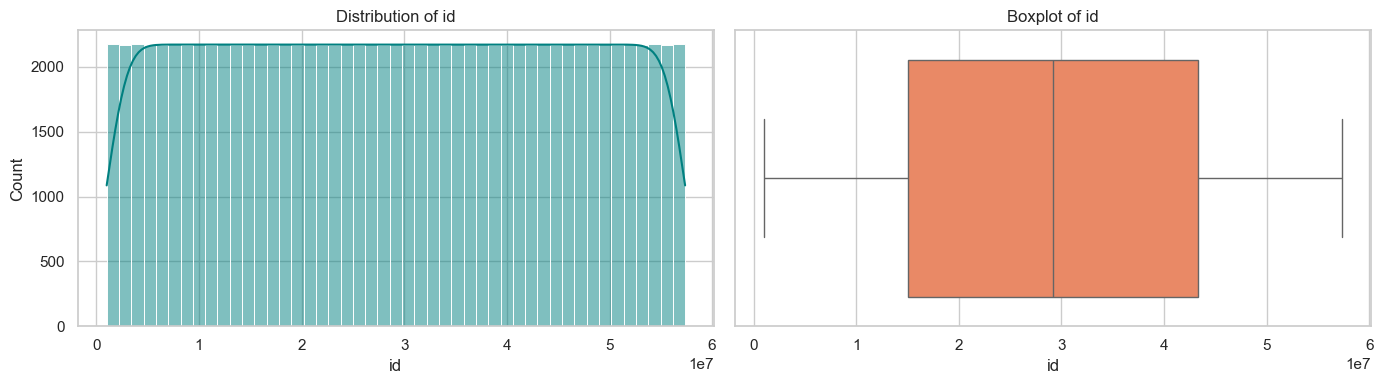

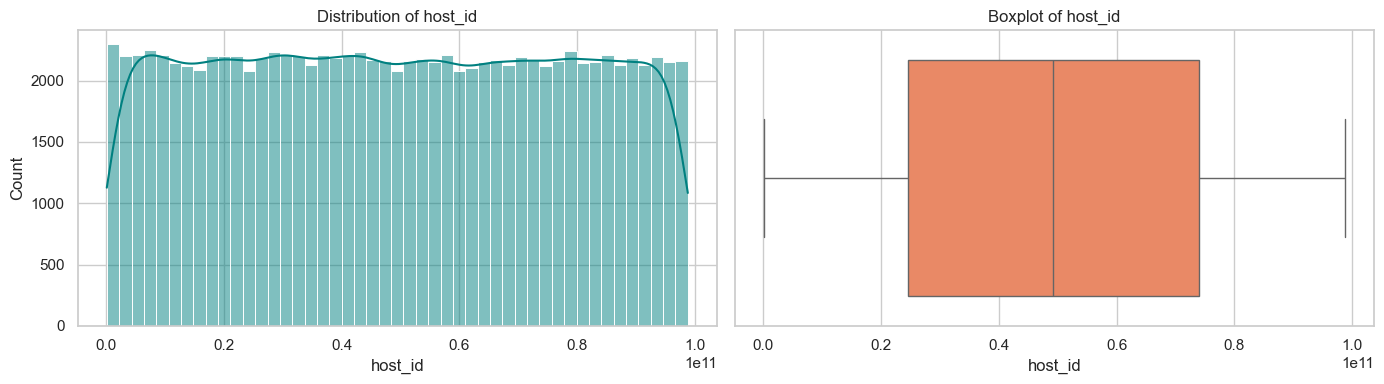

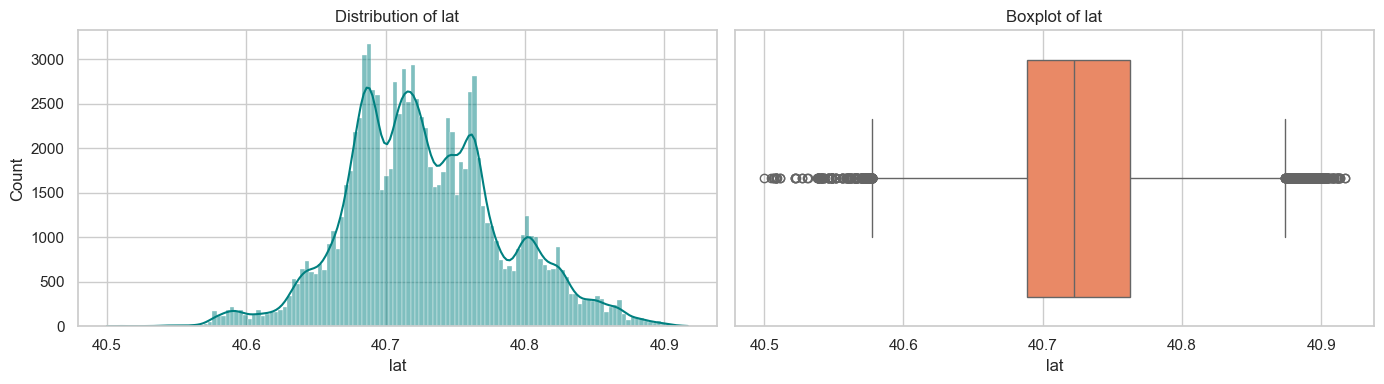

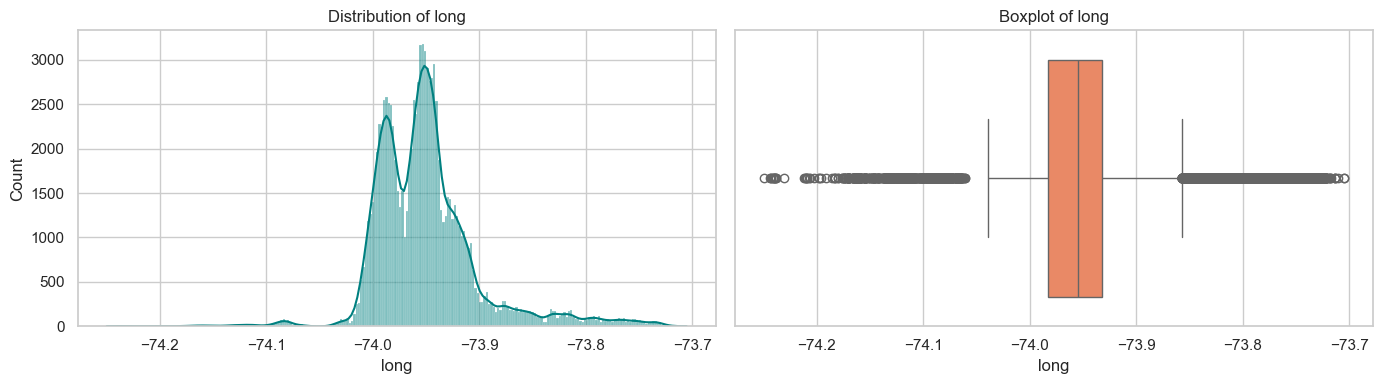

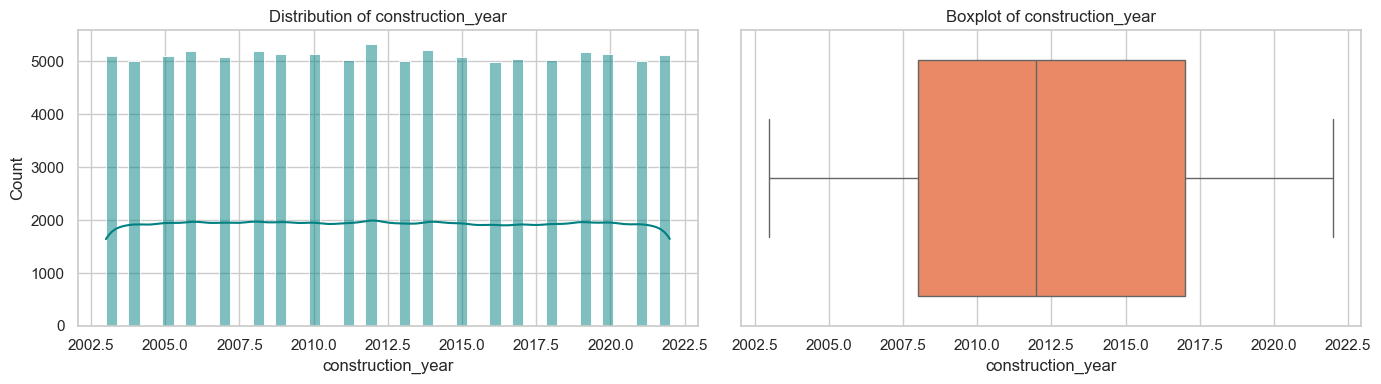

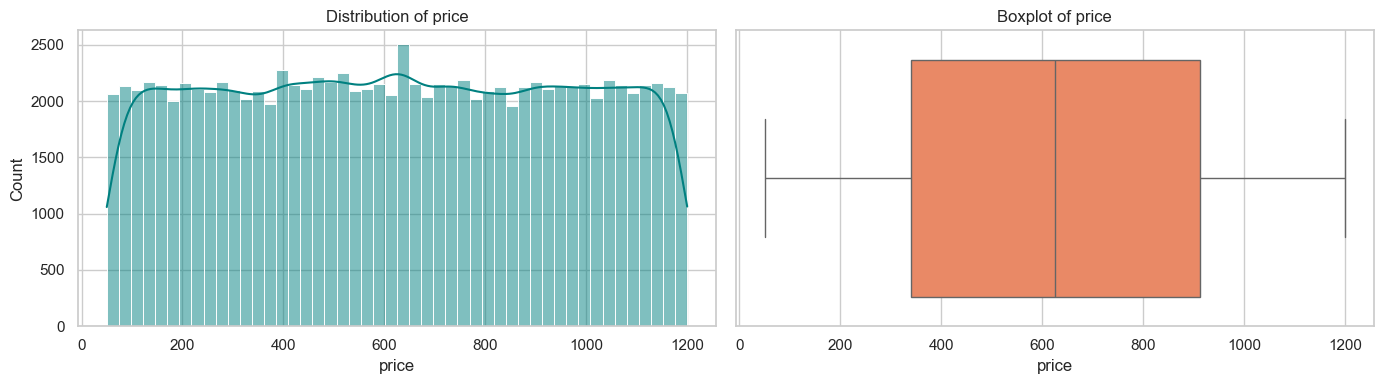

In [132]:
numeric_features = [col for col in df.select_dtypes(include=[np.number]).columns if df[col].nunique() > 5]
for col in numeric_features[:6]:  # limit to top features for readability
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    sns.histplot(df[col], kde=True, ax=axes[0], color='teal')
    axes[0].set_title(f'Distribution of {col}')
    sns.boxplot(x=df[col], ax=axes[1], color='coral')
    axes[1].set_title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

    fig_path = FIGURES_DIR / f'univariate_{col}.png'
    fig.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.close(fig)

In [133]:
categorical_features = [col for col in df.select_dtypes(include=['object', 'category']).columns if df[col].nunique() <= 20]
for col in categorical_features[:6]:
    counts = df[col].value_counts().head(15).sort_values(ascending=True)
    fig = px.bar(
        counts,
        title=f'Top {len(counts)} Categories for {col}',
        labels={'value': 'count', 'index': col}
    )
    fig.update_layout(height=400)
    fig.write_html(FIGURES_DIR / f'categorical_{col}.html')
    fig.show()

## 6. Bivariate & Multivariate Analysis

In [134]:
# Correlation heatmap for numeric features
corr_matrix = df.select_dtypes(include=[np.number]).corr()
fig = px.imshow(
    corr_matrix,
    text_auto=False,
    color_continuous_scale='RdBu_r',
    title='Correlation Heatmap'
)
fig.update_layout(height=700)
fig.write_html(FIGURES_DIR / 'correlation_heatmap.html')
fig.show()

In [135]:
# Scatter plots for key relationships

scatter_pairs = [

    ('accommodates', 'price'),

    ('number_of_reviews', 'price'),

    ('availability_365', 'price'),

    ('minimum_nights', 'price')

]

for x_col, y_col in scatter_pairs:

    if {x_col, y_col}.issubset(df.columns):

        sample_df = df.sample(min(5000, len(df)), random_state=42)

        color_arg = 'room_type' if 'room_type' in sample_df.columns else None

        fig = px.scatter(

            sample_df,

            x=x_col,

            y=y_col,

            color=color_arg,

            trendline='ols',

            title=f'{y_col} vs {x_col}'

        )

        fig.update_layout(height=500)

        fig.write_html(FIGURES_DIR / f'scatter_{y_col}_vs_{x_col}.html')

        fig.show()

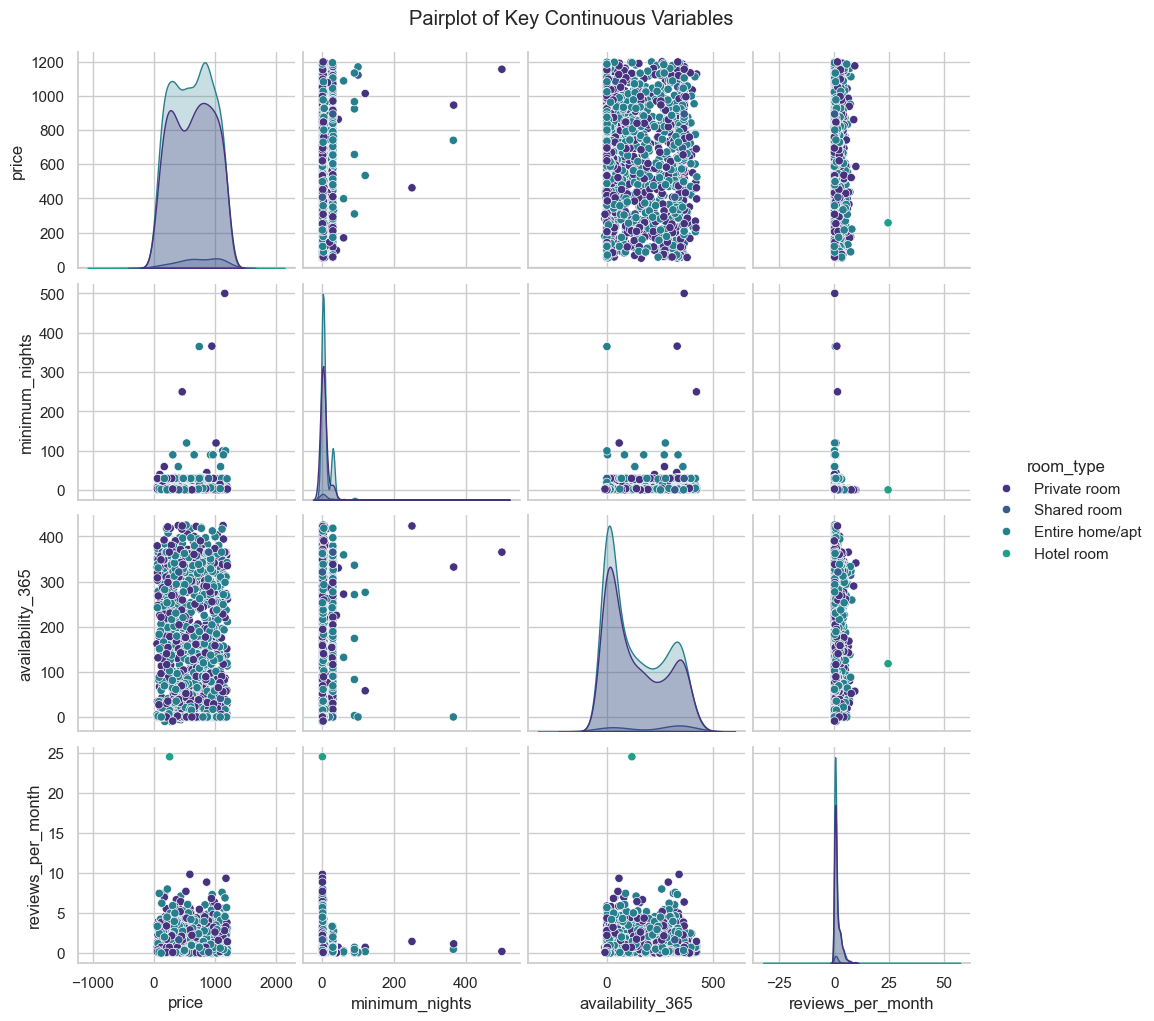

In [136]:
selected_cols = [col for col in ['price', 'accommodates', 'minimum_nights', 'availability_365', 'reviews_per_month'] if col in df.columns]

if len(selected_cols) >= 3:

    base_cols = selected_cols.copy()

    if 'room_type' in df.columns and 'room_type' not in base_cols:

        base_cols.append('room_type')

    sample_df = df[base_cols].sample(min(1500, len(df)), random_state=42)

    hue_col = 'room_type' if 'room_type' in sample_df.columns else None

    pairplot = sns.pairplot(sample_df, hue=hue_col, diag_kind='kde')

    pairplot.fig.suptitle('Pairplot of Key Continuous Variables', y=1.02)

    pairplot.savefig(FIGURES_DIR / 'pairplot_key_features.png', dpi=150, bbox_inches='tight')

    plt.show()

else:

    print('Not enough numeric features for pairplot.')

### Additional Visual Perspectives




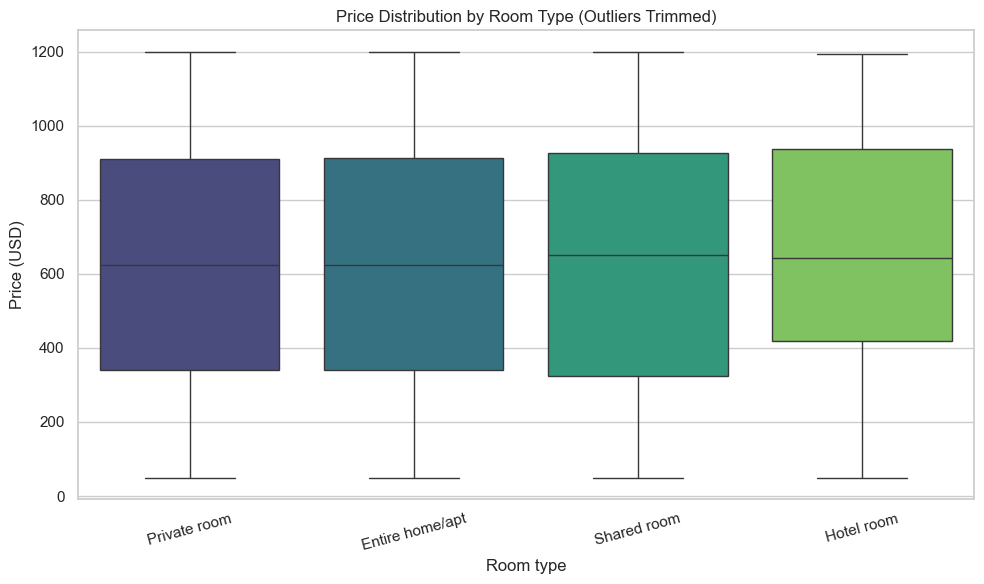

In [144]:
if {'price', 'room_type'}.issubset(df.columns):

    plt.figure(figsize=(10, 6))

    sns.boxplot(data=df, x='room_type', y='price', showfliers=False, palette='viridis')

    plt.title('Price Distribution by Room Type (Outliers Trimmed)')

    plt.xlabel('Room type')

    plt.ylabel('Price (USD)')

    plt.xticks(rotation=15)

    boxplot_path = FIGURES_DIR / 'price_boxplot_by_room_type.png'

    plt.tight_layout()

    plt.savefig(boxplot_path, dpi=150)

    plt.show()

    

else:

    print('Columns price/room_type not available for boxplot.')

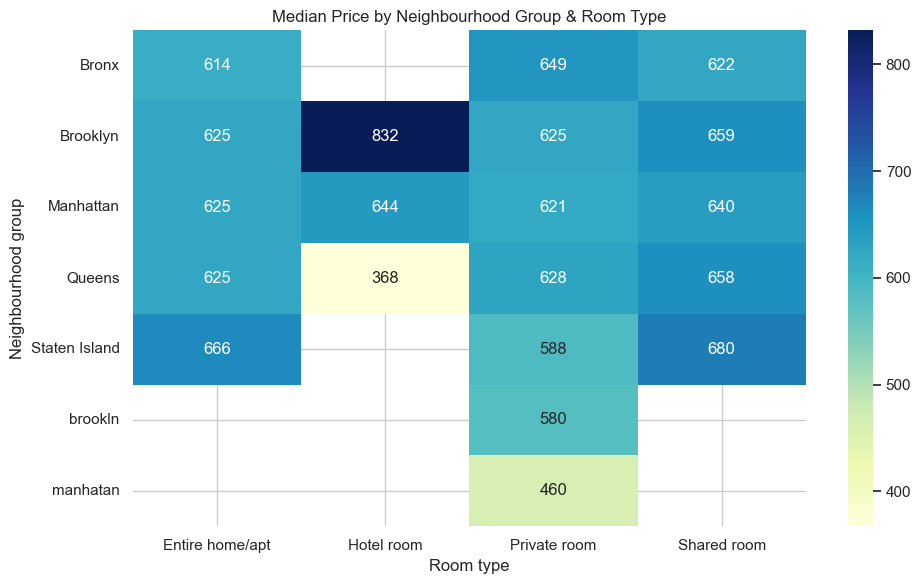

In [138]:
if {'neighbourhood_group', 'room_type', 'price'}.issubset(df.columns):

    price_pivot = df.pivot_table(index='neighbourhood_group', columns='room_type', values='price', aggfunc='median')

    plt.figure(figsize=(10, 6))

    sns.heatmap(price_pivot, annot=True, fmt='.0f', cmap='YlGnBu')

    plt.title('Median Price by Neighbourhood Group & Room Type')

    plt.xlabel('Room type')

    plt.ylabel('Neighbourhood group')

    heatmap_path = FIGURES_DIR / 'median_price_heatmap.png'

    plt.tight_layout()

    plt.savefig(heatmap_path, dpi=150)

    plt.show()

    

else:

    print('Required columns for heatmap missing.')

In [139]:
if 'host_name' in df.columns:

    top_hosts = df['host_name'].value_counts().head(10).sort_values(ascending=True)

    fig = px.bar(

        top_hosts,

        orientation='h',

        labels={'value': 'Listing count', 'index': 'Host name'},

        title='Top 10 Hosts by Active Listings'

    )

    fig.update_layout(height=500)

    fig.write_html(FIGURES_DIR / 'top_hosts_by_listings.html')

    fig.show()

else:

    print('host_name column not available for top host chart.')

In [140]:
if {'price', 'service_fee'}.issubset(df.columns):

    fee_columns = ['price', 'service_fee'] + (['room_type'] if 'room_type' in df.columns else [])

    fee_df = df[fee_columns].dropna()

    sample_size = min(5000, len(fee_df))

    fee_sample = fee_df.sample(sample_size, random_state=42) if sample_size > 0 else fee_df

    if not fee_sample.empty:

        fig = px.scatter(

            fee_sample,

            x='service_fee',

            y='price',

            color='room_type' if 'room_type' in fee_sample.columns else None,

            trendline='ols',

            title='Price vs Service Fee'

        )

        fig.update_layout(height=500)

        fig.write_html(FIGURES_DIR / 'price_vs_service_fee.html')

        fig.show()

    else:

        print('Insufficient non-null records for service_fee scatter plot.')

else:

    print('service_fee column unavailable for scatter plot.')

## 7. Time-Series Exploration

Investigate temporal patterns leveraging review or scrape dates.

In [141]:
time_columns = [col for col in ['last_review', 'first_review', 'calendar_last_scraped'] if col in df.columns]

if time_columns:

    time_col = time_columns[0]

    ts_df = df.dropna(subset=[time_col]).copy()

    ts_df = ts_df.set_index(time_col).sort_index()

    if 'price' in ts_df.columns:

        monthly_trend = ts_df['price'].resample('M').median().rename('median_price').to_frame()

        monthly_trend['rolling_3m'] = monthly_trend['median_price'].rolling(3).mean()



        fig = go.Figure()

        fig.add_trace(go.Scatter(x=monthly_trend.index, y=monthly_trend['median_price'], name='Median price', mode='lines'))

        fig.add_trace(go.Scatter(x=monthly_trend.index, y=monthly_trend['rolling_3m'], name='3M Rolling Avg', mode='lines'))

        fig.update_layout(title=f'Monthly Median Price Trend (based on {time_col})', xaxis_title='Month', yaxis_title='Price')

        fig.write_html(FIGURES_DIR / 'monthly_price_trend.html')

        fig.show()

    else:

        print('Price column not available for time-series trend analysis.')

else:

    print('No review or scrape date columns present for time-series analysis.')

## 8. Statistical Testing

Quantify significance of observed differences.

In [142]:
stats_results = {}


# 8.1 Two-sample t-test: Entire home vs Private room pricing
if {'room_type', 'price'}.issubset(df.columns):
    room_mask = df['room_type'].isin(['Entire home/apt', 'Private room'])
    sub = df.loc[room_mask, ['room_type', 'price']]
    if sub['room_type'].nunique() == 2:
        group_prices = [grp['price'].values for _, grp in sub.groupby('room_type')]
        t_stat, p_value = stats.ttest_ind(*group_prices, equal_var=False)
        stats_results['t_test_price_room_type'] = {'t_statistic': t_stat, 'p_value': p_value}


# 8.2 Chi-square test: Neighbourhood group vs room type
if {'neighbourhood_group', 'room_type'}.issubset(df.columns):
    contingency = pd.crosstab(df['neighbourhood_group'], df['room_type'])
    chi2_stat, chi2_p, dof, expected = stats.chi2_contingency(contingency)
    stats_results['chi_square_neighbourhood_room'] = {'chi2_statistic': chi2_stat, 'p_value': chi2_p, 'dof': dof}


# 8.3 One-way ANOVA: Price differences across top neighbourhood groups
if {'neighbourhood_group', 'price'}.issubset(df.columns):
    top_groups = df['neighbourhood_group'].value_counts().head(4).index
    samples = [df.loc[df['neighbourhood_group'] == grp, 'price'].values for grp in top_groups]
    if len(samples) >= 2:
        f_stat, p_val = stats.f_oneway(*samples)
        stats_results['anova_price_neighbourhood_group'] = {'f_statistic': f_stat, 'p_value': p_val, 'groups': list(top_groups)}


stats_results_df = pd.DataFrame(stats_results).T

display(stats_results_df)

t_statistic p_value chi2_statistic   dof  \
t_test_price_room_type                 0.14    0.89            NaN   NaN   
chi_square_neighbourhood_room           NaN    0.00       2,707.66 18.00   
anova_price_neighbourhood_group         NaN    0.10            NaN   NaN   

                                f_statistic  \
t_test_price_room_type                  NaN   
chi_square_neighbourhood_room           NaN   
anova_price_neighbourhood_group        2.10   

                                                               groups  
t_test_price_room_type                                            NaN  
chi_square_neighbourhood_room                                     NaN  
anova_price_neighbourhood_group  [Manhattan, Brooklyn, Queens, Bronx]

In [143]:
# cleaned_data_path = OUTPUT_DIR / 'airbnb_cleaned.csv'

# df.to_csv(cleaned_data_path, index=False)

# print(f'Clean dataset exported to: {cleaned_data_path}')


# artefacts = {
#     'cleaned_dataset': cleaned_data_path.as_posix(),
#     'figures_directory': FIGURES_DIR.as_posix()
# }

# artefacts

## 10. Key Insights & Next Steps

- **Pricing drivers:** Room type, capacity, and neighbourhood segments materially shift rate cards — revisit scatter plots and grouped summaries for precise deltas.
- **Demand signals:** `reviews_per_month`, `days_since_last_review`, and availability buckets flag hot listings versus dormant ones.
- **Seasonality:** Monthly median price trend plus rolling averages surface off-peak periods worth promotional targeting.
- **Host concentration:** A small cohort of hosts controls many listings; monitor their pricing strategies and risk exposure.
- **Statistical validation:** Significant p-values in t-tests/ANOVA back up observed differences — confirm assumptions before operational roll-out.

